# Phase 1 — Inference–Validation Cycle

Use the cells below to configure models, servers, and run parameters via Pydantic models (`ModelPreset`, `ServerConfig`, `RunParams`, `InferenceValidationRun`).

Steps:
- Ensure two MLNodes are running and reachable (`ip`, `node_port`, `inference_port`).
- Set up:
    - Run parameters
    - Models
    - Servers
- Populate `runs` list with necessary runs
- Run Run the deployment and execution cell to produce JSONL outputs
- Set up paths to jsons in DATA_PATHS
- Plot analysis graphs 
- Add one or more `InferenceValidationRun` instances to the `runs` list

In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
sys.path.append('../../common/src')
from validation.runner import run_validation
from validation.data import (
    ModelInfo,
    RequestParams,
    save_to_jsonl,
    ModelPreset,
    ServerConfig,
    RunParams,
    InferenceValidationRun,
)
import requests
from time import sleep 
from transformers import AutoTokenizer
import os
import copy
from concurrent.futures import ThreadPoolExecutor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Phase 2 — Analysis and Threshold Estimation

Use the cells below to load the generated JSONL files and estimate thresholds.

- Populate `DATA_PATHS` with paths from Phase 1 outputs.
- Define `comparisons` with one honest JSONL and one fraud JSONL per model.
- Run analysis cells to compute distances, plot distributions, and search the optimal threshold.


In [12]:
# DATA_PATHS = {
#     'honest_qwen30_H100vsH100': '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-FP8-fp8-1xH100___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-1xH100__optim__2025-10-16_1415.jsonl',
#     'fraud_qwen30_H100vsH100': '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-AWQ-4bit-int4-1xH100___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-1xH100__optim__2025-10-16_1521.jsonl',
#     'honest_qwen30_3090vsH100': '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-FP8-fp8-2x3090___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-1xH100__optim__2025-10-16_1950.jsonl',
#     'fraud_qwen30_3090vsH100': '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-AWQ-4bit-int4-2x3090___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-1xH100__optim__2025-10-16_2007.jsonl',
#     'honest_qwen30_3090vs3090': '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-FP8-fp8-2x3090___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-2x3090__optim__2025-10-16_2027.jsonl'
# }

def generate_name_from_config(jsonl_path, model_short_name):
    """Generate a descriptive name from a config file based on the jsonl path.
    
    Args:
        jsonl_path: Path to the jsonl file (e.g., '../data/inference_results/...__2025-10-21_1426.jsonl')
        model_short_name: Short name for the model (e.g., 'qwen235')
    
    Returns:
        A string like 'honest_qwen235_H100vsH100' or 'fraud_qwen30_H100vs3090'
        - 'honest' if inference and validation models are the same, 'fraud' if different
        - underscore
        - the short model name provided
        - GPU from inference vs GPU from validation
    """
    # Replace .jsonl with _config.json to get config path
    if jsonl_path.endswith('.jsonl'):
        config_path = jsonl_path.replace('.jsonl', '_config.json')
    else:
        config_path = jsonl_path + '_config.json'
    
    # Check if config file exists
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found: {config_path}")
    
    # Load config
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    # Check if models are the same
    model_inference = config['model_inference']['model']
    model_validation = config['model_validation']['model']
    is_honest = (model_inference == model_validation)
    honesty_label = 'honest' if is_honest else 'fraud'
    
    # Extract GPU information
    gpu_inference = config['server_inference']['gpu']
    gpu_validation = config['server_validation']['gpu']
    
    # Create the name
    name = f"{honesty_label}_{model_short_name}_{gpu_inference}vs{gpu_validation}"
    
    return name

# DATA_PATHS = {
#     'honest_qwen235_H100vsH100': '../data/inference_results/Qwen3-235B-A22B-Instruct-2507-FP8-fp8-8xH100___Qwen3-235B-A22B-Instruct-2507-FP8-fp8-8xH100__235_repro__2025-10-21_1426.jsonl',
#     'fraud_qwen235_H100vsH100': '../data/inference_results/Qwen3-235B-A22B-Instruct-2507-INT4-W4A16-int4-8xH100___Qwen3-235B-A22B-Instruct-2507-FP8-fp8-8xH100__235_repro__2025-10-21_1504.jsonl',
#     # 'honest_qwen235_H100vsH200': '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-FP8-fp8-2x3090___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-1xH100__optim__2025-10-16_1950.jsonl',
#     # 'fraud_qwen30_3090vsH100': '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-AWQ-4bit-int4-2x3090___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-1xH100__optim__2025-10-16_2007.jsonl',
#     # 'honest_qwen30_3090vs3090': '../data/inference_results/Qwen3-30B-A3B-Instruct-2507-FP8-fp8-2x3090___Qwen3-30B-A3B-Instruct-2507-FP8-fp8-2x3090__optim__2025-10-16_2027.jsonl'
# }

In [30]:
import json
import os
model_name = 'qwen235'

honest_data_paths = ['../data/inference_results/Qwen3-235B-A22B-Instruct-2507-FP8-fp8-4xH100___Qwen3-235B-A22B-Instruct-2507-FP8-fp8-4xH200__235_repro__2025-10-21_1757.jsonl']
fraud_data_paths = ['../data/inference_results/Qwen3-235B-A22B-Instruct-2507-INT4-W4A16-int4-4xH100___Qwen3-235B-A22B-Instruct-2507-FP8-fp8-4xH100__235_repro__2025-10-21_1732.jsonl']

DATA_PATH = {generate_name_from_config(dp, model_name): dp for dp in honest_data_paths + fraud_data_paths}

In [31]:
import sys
sys.path.append('../src')
sys.path.append('../../common/src')

import numpy as np
from validation.data import (
    load_from_jsonl,
)

from validation.analysis import analyze, process_data, plot_distances_and_matches, plot_classification_results, find_optimal_bounds_parallel, evaluate_bound, classify_data
from validation.utils import distance, token_distance2, distance2
from validation import stats
import matplotlib.pyplot as plt

Below are graphs:
- Distance depending on the number of tokens
- Percentage of top-k matches for inference and validation.

For each inference-validation cycle (2 setups: honest and fraudulent inference) we can observe this distributions to build an intuition how the distance function works.

In [32]:
from validation.analysis import plot_length_vs_distance_comparison, find_optimal_bounds_parallel

In [47]:
honest_items_dict, honest_distances_dict = {}, {}
fraud_items_dict, fraud_distances_dict = {}, {}
for name, path in DATA_PATH.items():
    items, distances, topk = process_data(load_from_jsonl(path, n=1000))
    if 'honest' in name:
        honest_items_dict[name] = items
        honest_distances_dict[name] = distances
    if 'fraud' in name:
        fraud_items_dict[name] = items
        fraud_distances_dict[name] = distances

Dropped 0 / 1000 items
Dropped 0 / 1000 items


In [48]:
honest_distances = []
for v in honest_distances_dict.values():
    honest_distances.extend(v)

fraud_distances = []
for v in fraud_distances_dict.values():
    fraud_distances.extend(v)

In [49]:
optimal_lower, optimal_upper = find_optimal_bounds_parallel(honest_distances, fraud_distances, n_jobs=64, step=0.001)

Searching optimal bounds: 100%|███████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 22829.32it/s]


Optimal Lower Bound: 0.040733
Optimal Upper Bound: 0.041733
Best F1-Score: 0.4000


0.236


Thresholds: 0.0407, 0.0417
Pecentage= 0.236


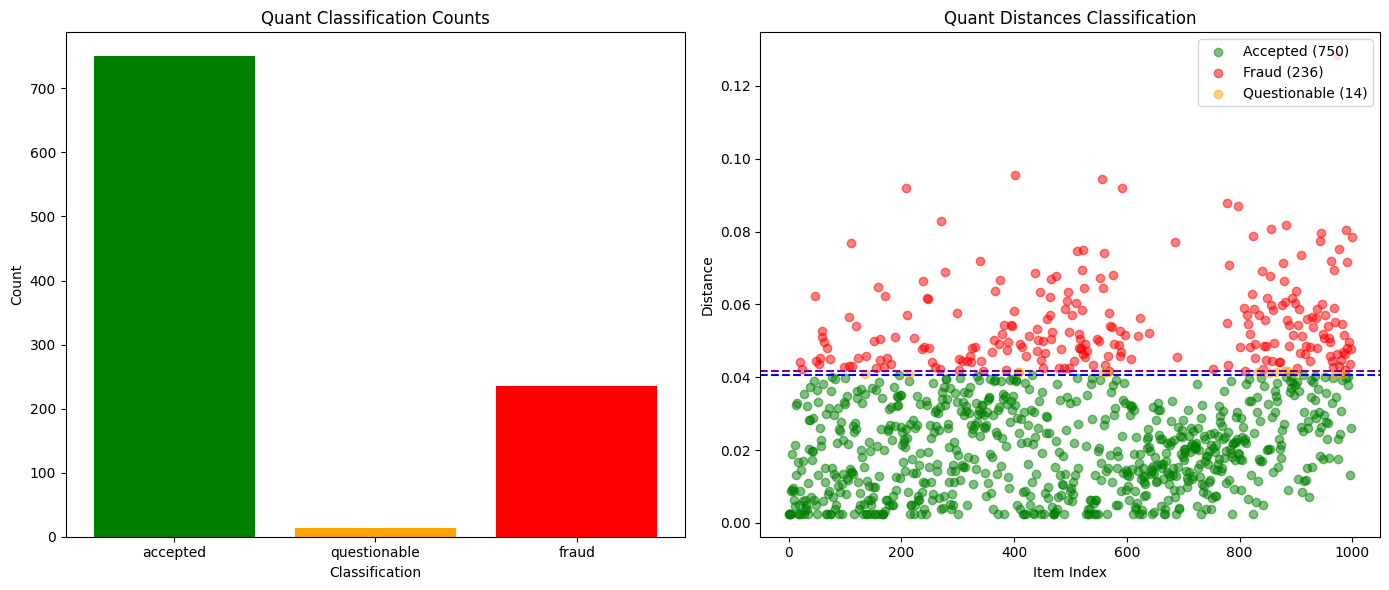

/root/gonka/mlnode/packages/benchmarks/notebooks/../src/validation/analysis.py:352: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  unique_languages.append(lang)


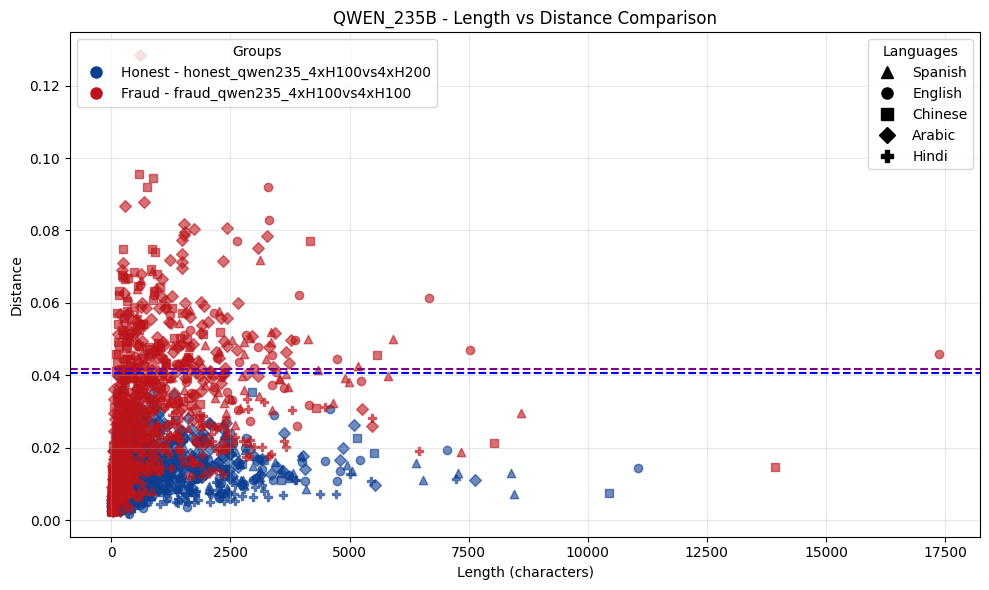

In [65]:
from validation.analysis import plot_length_vs_distance_comparison
print(f"Thresholds: {optimal_lower:.4f}, {optimal_upper:.4f}")

print('Pecentage=', sum(np.array(classifications_fraud) == 'fraud')/len(classifications_fraud))
classifications_fraud = classify_data(fraud_distances, optimal_lower, optimal_upper)
plot_classification_results(
    fraud_distances, classifications_fraud, optimal_lower, optimal_upper, title_prefix="Quant"
)
plot_length_vs_distance_comparison('QWEN_235B',
                                   honest_items_dict,
                                   honest_distances_dict,
                                   fraud_items_dict,
                                   fraud_distances_dict,
                                   bounds = (optimal_lower, optimal_upper)
                                  )


In [176]:
import seaborn as sns
import pandas as pd
def plot_violin_comparison(distributions_dict, title="Distance Distributions", ylabel="Distance", figsize=(10, 6), show=True, ylim=None):
    """Draw a violin plot for a dict of lists of floats and print mean/variance report.

    Parameters
    ----------
    distributions_dict : Dict[str, Sequence[float]]
        Mapping from group name to list/array of numeric values.
    title : str
        Plot title.
    ylabel : str
        Y-axis label.
    figsize : Tuple[int, int]
        Matplotlib figure size.
    show : bool
        Whether to call plt.show().
    ylim : Optional[Tuple[float, float]]
        Y-limits for the plot.
    """
    if not isinstance(distributions_dict, dict) or not distributions_dict:
        print("Nothing to plot: empty or invalid input.")
        return

    group_names = []
    group_values = []
    long_groups = []

    # Clean inputs and build long-form arrays
    for name, values in distributions_dict.items():
        arr = np.asarray(values, dtype=float)
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            continue
        group_names.append(name)
        group_values.append(arr)
        long_groups.extend([name] * arr.size)

    if not group_values:
        print("Nothing to plot: all groups are empty after cleaning.")
        return

    all_values = np.concatenate(group_values)
    df = pd.DataFrame({"group": long_groups, "value": all_values})

    plt.figure(figsize=figsize)
    ax = sns.violinplot(data=df, x="group", y="value", inner="quartile", cut=0)
    ax.set_title(title)
    ax.set_xlabel("Group")
    ax.set_ylabel(ylabel)
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.tight_layout()
    if show:
        plt.show()

    # Stats report
    print("Mean and variance per group:")
    means = {}
    variances = {}
    counts = {}
    for name, arr in zip(group_names, group_values):
        counts[name] = int(arr.size)
        means[name] = float(np.mean(arr)) if arr.size > 0 else float("nan")
        variances[name] = float(np.var(arr, ddof=1)) if arr.size > 1 else float("nan")

    # Print sorted by mean for quick comparison
    for name in sorted(group_names, key=lambda k: means[k]):
        m = means[name]
        v = variances[name]
        n = counts[name]
        m_str = f"{m:.6f}" if np.isfinite(m) else "nan"
        v_str = f"{v:.6f}" if np.isfinite(v) else "nan"
        print(f"  {name}: n={n}, mean={m_str}, var={v_str}")

    if len(group_names) >= 2:
        # Highlight range of means and variances
        max_mean_key = max(group_names, key=lambda k: means[k])
        min_mean_key = min(group_names, key=lambda k: means[k])
        if np.isfinite(means[max_mean_key]) and np.isfinite(means[min_mean_key]):
            delta_mean = means[max_mean_key] - means[min_mean_key]
            print(f"Delta mean: {delta_mean:.6f} ({min_mean_key} -> {max_mean_key})")

        finite_vars = {k: v for k, v in variances.items() if np.isfinite(v)}
        if len(finite_vars) >= 2:
            max_var_key = max(finite_vars, key=lambda k: finite_vars[k])
            min_var_key = min(finite_vars, key=lambda k: finite_vars[k])
            print(
                f"Variance range: {finite_vars[min_var_key]:.6f} ({min_var_key}) .. "
                f"{finite_vars[max_var_key]:.6f} ({max_var_key})"
            )

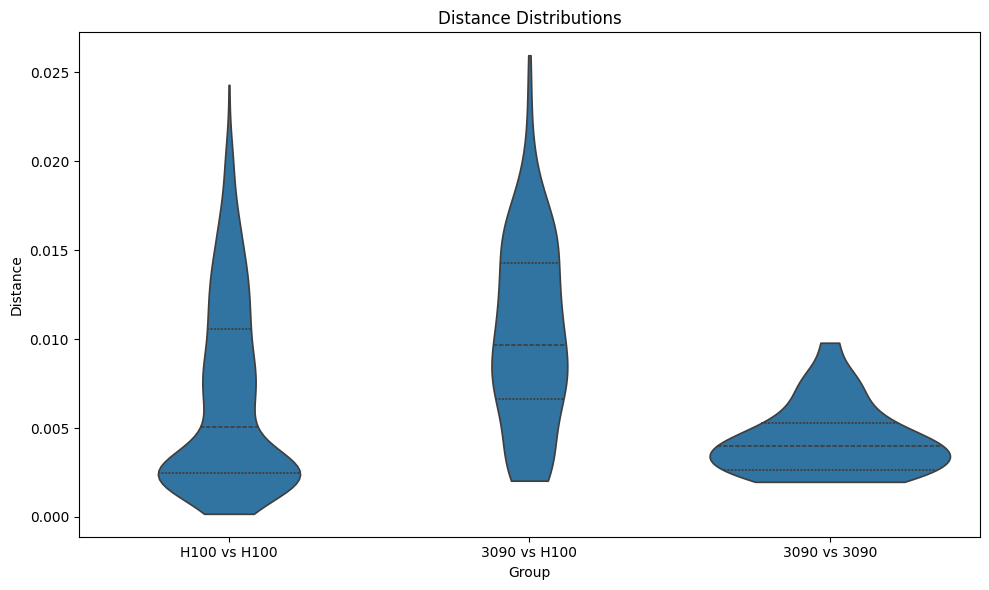

Mean and variance per group:
  3090 vs 3090: n=31, mean=0.004331, var=0.000004
  H100 vs H100: n=1000, mean=0.006755, var=0.000027
  3090 vs H100: n=200, mean=0.010275, var=0.000026
Delta mean: 0.005944 (3090 vs 3090 -> 3090 vs H100)
Variance range: 0.000004 (3090 vs 3090) .. 0.000027 (H100 vs H100)


In [177]:
plot_violin_comparison(honest_distances_dict)

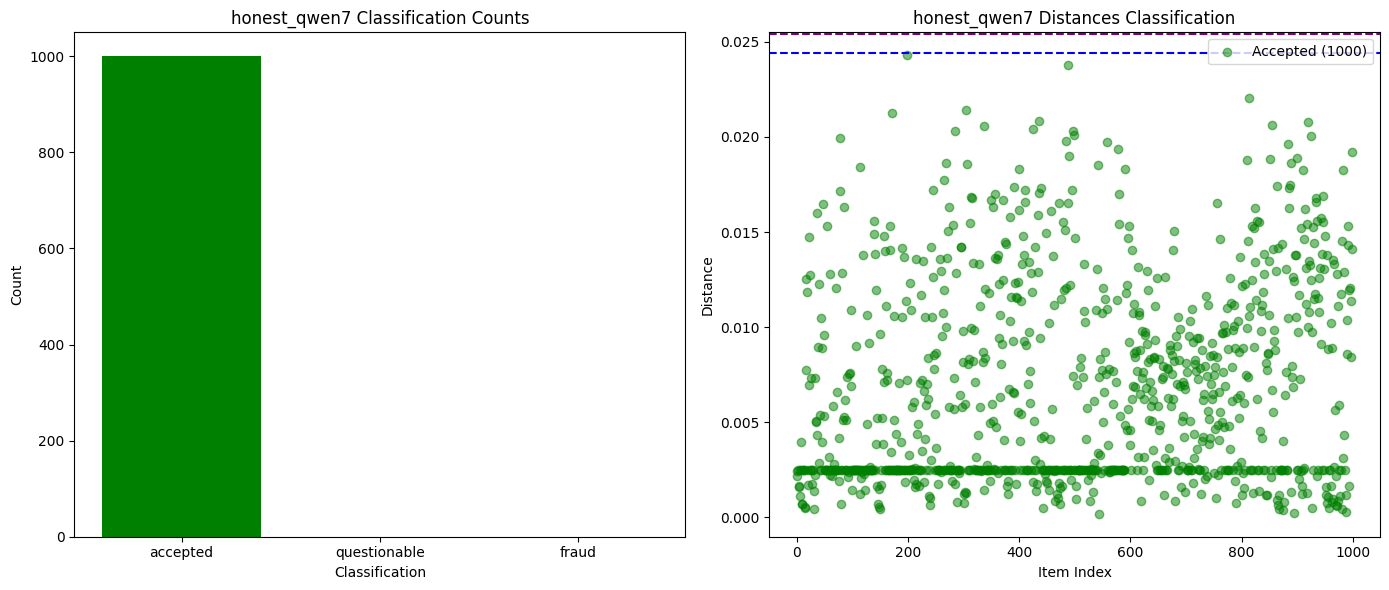

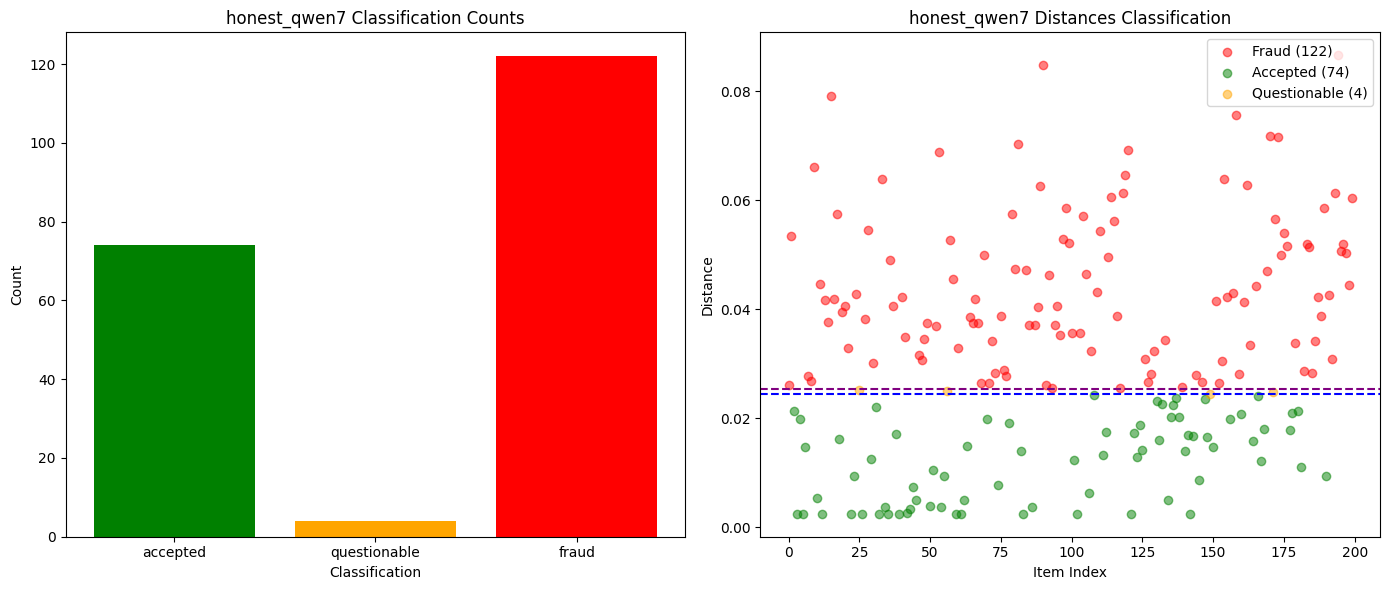

0.02442685600945907 0.02542685600945907


In [132]:
classifications_full = classify_data(honest_distances_H100vsH100, optimal_lower, optimal_upper)
classifications_fraud = classify_data(fraud_distances_H100vsH100, optimal_lower, optimal_upper)

plot_classification_results(
        honest_distances_H100vsH100, classifications_full, optimal_lower, optimal_upper, title_prefix=name
    )
plot_classification_results(
        fraud_distances_H100vsH100, classifications_fraud, optimal_lower, optimal_upper, title_prefix=name
    )
print(optimal_lower, optimal_upper)

Below are illustrations of classification using the found estimations for the best distance threshold.

There is a pair of graphs, each pair consists of honest inference-validation (in FP8) and fraudulent (quantized INT4) inference + honest (fp8) validation.

- Full classification counts is just a bar chart of the number of TP for detecting honest inference.
- Full distances classification is illustration of how far typical distances are related to the threshold.
- Quant classification counts shows classification results for the fraudulent inference.
- Quant distances classification shows how distance thresholds relates to the typical distance range for the fraudulent inference.

For each model we have these 4 graphs that depict how well can we distinguish honest and quantized inference using the distance threshold.

qwen_orig


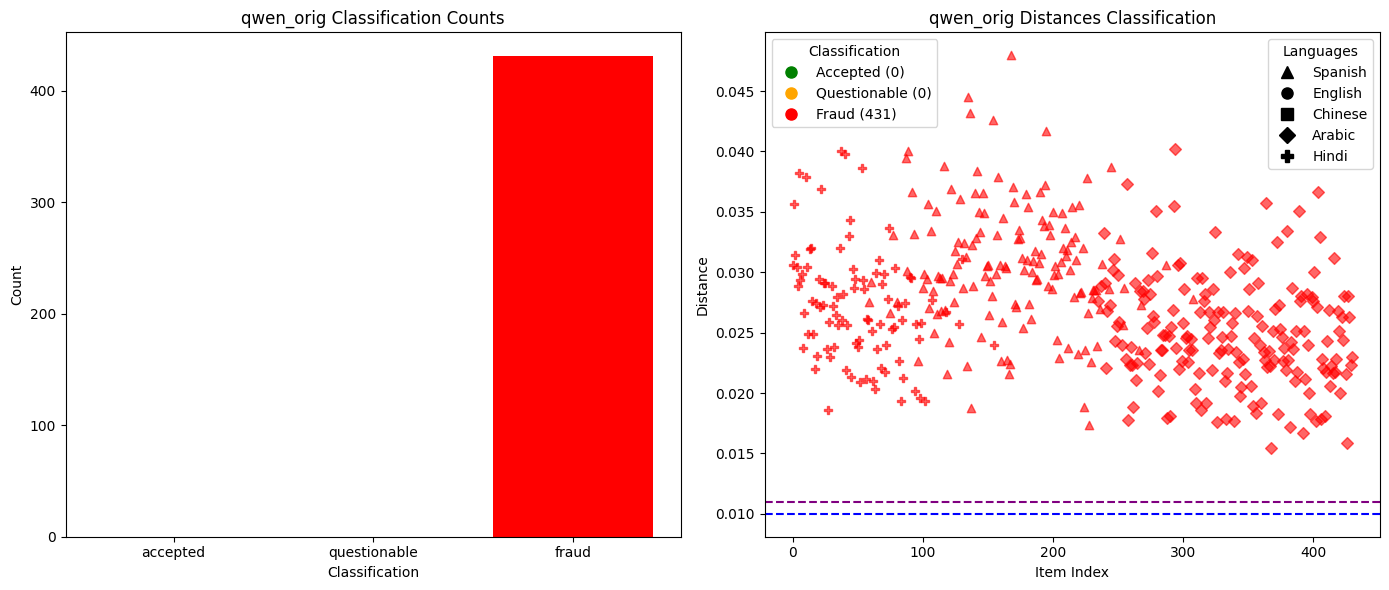

In [8]:
for name, comparison in comparisons:
    print('='*80)
    print(name)
    
    distances_honest = data_path_to_distances[comparison['honest']]
    distances_fraud = data_path_to_distances[comparison['fraud']]
    langs = data_path_to_langs[comparison['honest']]
    
    classifications_full = classify_data(distances_honest, optimal_lower, optimal_upper)
    
    plot_classification_results(
        distances_honest, classifications_full, optimal_lower, optimal_upper, title_prefix=name, languages=langs
    )

Threshold is chosen between Optimal Lower Bound and Optimal Upper Bound